In [1]:
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

/Users/visser/drive/PhD/Code/pain-measurement


In [2]:
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from src.expyriment.estimator import BayesianEstimatorVAS
from src.log_config import configure_logging

configure_logging(stream_level=logging.DEBUG, ignore_libs=["matplotlib", "Comm"])

In [3]:
def plot_trials(estimator, interactive=True):
    priors = estimator.priors
    likelihoods = estimator.likelihoods
    posteriors = estimator.posteriors
    range_temperature = estimator.range_temp
    min_temperature = estimator.min_temp
    max_temperature = estimator.max_temp
    trials = estimator.trials

    if interactive:
        # reload vs window if plot appears twice
        import ipywidgets as widgets
        from IPython.display import display

        def plot_trial(trial):
            plt.clf()
            plt.plot(range_temperature, priors[trial], label="Prior")
            plt.plot(range_temperature, likelihoods[trial], label="Likelihood")
            plt.plot(range_temperature, posteriors[trial], label="Posterior")
            plt.title(f"Trial {trial+1} of {trials}")
            plt.xlim([min_temperature, max_temperature])
            plt.ylim([0, 1])
            plt.xlabel("Temperature (°C)")
            plt.ylabel("Probability")
            plt.xticks(np.arange(min_temperature, max_temperature + 1, 1))
            plt.legend(bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=3)

        # Create a slider for the trial number
        trial_slider = widgets.IntSlider(min=0, max=trials - 1, step=1, value=0)
        # Create Next and Previous buttons, define click events and link them to the buttons
        next_button = widgets.Button(description="Next")
        prev_button = widgets.Button(description="Previous")

        def next_button_clicked(b):  # b is the button instance
            if trial_slider.value < trial_slider.max:
                trial_slider.value += 1

        def prev_button_clicked(b):
            if trial_slider.value > trial_slider.min:
                trial_slider.value -= 1

        next_button.on_click(next_button_clicked)
        prev_button.on_click(prev_button_clicked)

        # Use the interact function to automatically update the plot when the slider is moved
        out = widgets.interactive_output(plot_trial, {"trial": trial_slider})
        # Display the slider and the buttons on top of the figure (box on box)
        display(
            widgets.VBox([widgets.HBox([trial_slider, prev_button, next_button]), out])
        )

    else:
        # One figure with all trials
        fig, ax = plt.subplots(trials, 1, figsize=(5, estimator.trials * 1.7))
        for trial in range(trials):
            ax[trial].plot(range_temperature, priors[trial], label="Prior")
            ax[trial].plot(range_temperature, likelihoods[trial], label="Likelihood")
            ax[trial].plot(range_temperature, posteriors[trial], label="Posterior")
            ax[trial].set_title(f"Trial {trial+1}")
            ax[trial].set_xlim([min_temperature, max_temperature])
            ax[trial].set_xticks(np.arange(min_temperature, max_temperature + 1, 1))
            ax[trial].set_ylim([0, 1])
            ax[trial].set_yticks([0, 1])

            # Add x-axis label to the last diagram only
            if trial == trials - 1:
                ax[trial].set_xlabel("Temperature (°C)")
        plt.legend(bbox_to_anchor=(0.5, -0.5), loc="upper center", ncol=3)
        plt.tight_layout()
        plt.show()

# Visualization of Calibration

In [4]:
# Preexposure
preexposure_temperatures = [35, 36, 37]
correction_after_preexposure = 2

# VAS 70 estimation
trials_vas70 = 7
temp_start_vas70 = 42.0
temp_std_vas70 = 3.5

# VAS 0 estimation
trials_vas0 = 5
temp_start_vas0 = None  # based on VAS 70 estimation
temp_start_vas0_offset = 3
temp_std_vas0 = 1.5

In [5]:
response = input(
    f"Were any of the preexposure stimuli ({str(preexposure_temperatures)} °C) painful? (y/n) "
)
if response == "y":
    temp_start_vas70 = 42.0 - correction_after_preexposure
    logging.info(
        f"Calibration preexposure was painful. Starting temperature for VAS 70 estimation: {temp_start_vas70} °C."
    )
else:
    temp_start_vas70 = 42.0
    logging.info(
        f"Calibration preexposure was not painful. Starting temperature for VAS 70 estimation: {temp_start_vas70} °C."
    )

10:40:16 | INFO    | root | Calibration preexposure was not painful. Starting temperature for VAS 70 estimation: 42.0 °C.


In [6]:
# Get estimate for VAS 70
estimator_vas70 = BayesianEstimatorVAS(
    vas_value=70,
    temp_start=temp_start_vas70,
    temp_std=temp_std_vas70,
    trials=trials_vas70,
)

for trial in range(estimator_vas70.trials):
    response = input(
        f"Is this stimulus {estimator_vas70.current_temp} °C painful? (y/n) "
    )
    estimator_vas70.conduct_trial(response, trial=trial)

logging.info(f"Estimated temperature for VAS 70: {estimator_vas70.get_estimate()} °C")

10:40:16 | INFO    | estimator | Calibration trial (1/7): 42.0 °C was under VAS 70.
10:40:16 | INFO    | estimator | Calibration trial (2/7): 43.6 °C was under VAS 70.
10:40:16 | INFO    | estimator | Calibration trial (3/7): 44.8 °C was under VAS 70.
10:40:16 | INFO    | estimator | Calibration trial (4/7): 45.8 °C was under VAS 70.
10:40:16 | INFO    | estimator | Calibration trial (5/7): 46.6 °C was under VAS 70.
10:40:16 | WARNING | estimator | Maximum temperature of 47.0 °C reached.
10:40:16 | INFO    | estimator | Calibration trial (6/7): 47.0 °C was under VAS 70.
10:40:16 | WARNING | estimator | Maximum temperature of 47.0 °C reached.
10:40:16 | INFO    | estimator | Calibration trial (7/7): 47.0 °C was under VAS 70.
10:40:16 | WARNING | estimator | Maximum temperature of 47.0 °C reached.
10:40:16 | INFO    | estimator | Calibration estimate for VAS 70: 47.0 °C.
10:40:16 | DEBUG   | estimator | Calibration steps for VAS 70 were (°C): [1.6 1.2 1.  0.8 0.4 0.  0. ].
10:40:16 | ERR

In [7]:
plot_trials(estimator_vas70, interactive=True)

In [8]:
# Get estimate for VAS 0
estimator_vas0 = BayesianEstimatorVAS(
    vas_value=0,
    temp_start=estimator_vas70.get_estimate() - temp_start_vas0_offset,
    temp_std=temp_std_vas0,
    trials=trials_vas0,
)

for trial in range(estimator_vas0.trials):
    response = input("Is this stimulus painful? (y/n) ")
    estimator_vas0.conduct_trial(response, trial=trial)

logging.info(f"Estimated temperature for VAS 0: {estimator_vas0.get_estimate()} °C")

10:40:17 | INFO    | estimator | Calibration trial (1/5): 44.0 °C was under VAS 0.
10:40:17 | INFO    | estimator | Calibration trial (2/5): 44.8 °C was under VAS 0.
10:40:17 | INFO    | estimator | Calibration trial (3/5): 45.4 °C was under VAS 0.
10:40:17 | INFO    | estimator | Calibration trial (4/5): 45.9 °C was under VAS 0.
10:40:17 | INFO    | estimator | Calibration trial (5/5): 46.0 °C was under VAS 0.
10:40:17 | INFO    | estimator | Calibration estimate for VAS 0: 46.0 °C.
10:40:17 | DEBUG   | estimator | Calibration steps for VAS 0 were (°C): [0.8 0.6 0.5 0.1 0. ].
10:40:17 | ERROR   | estimator | Calibration steps for VAS 0 were all in the same direction.
10:40:17 | INFO    | root | Estimated temperature for VAS 0: 46.0 °C


In [9]:
plot_trials(estimator_vas0, interactive=True)

## Non-interactive plots

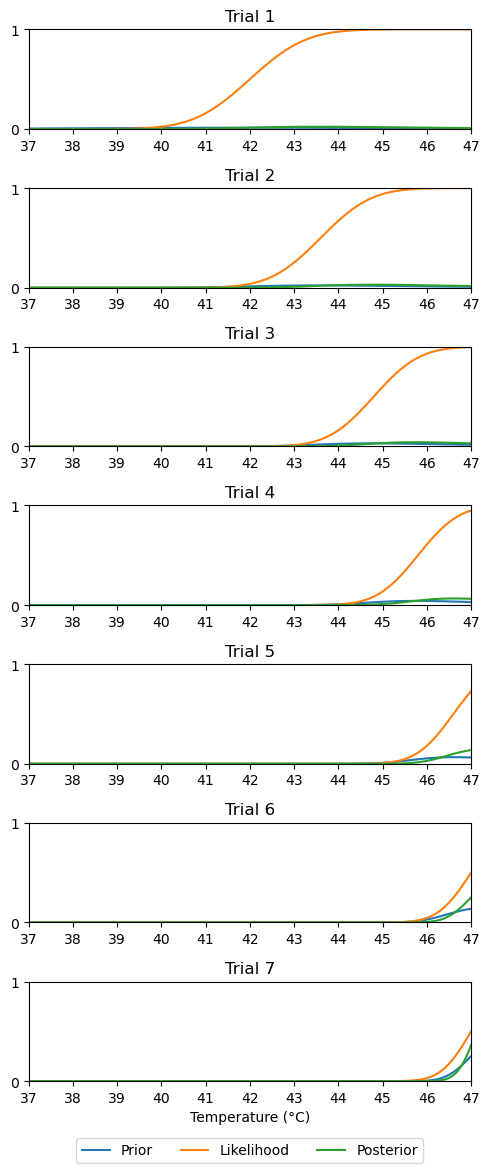

In [10]:
plot_trials(estimator_vas70, interactive=False)

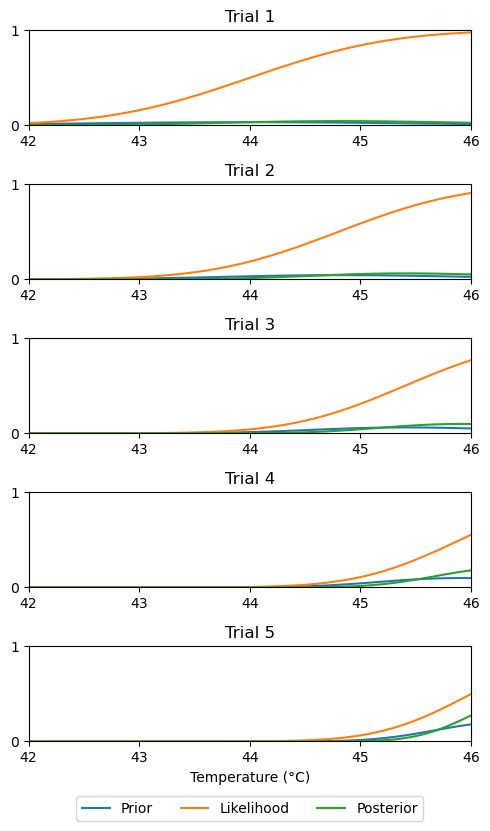

In [11]:
plot_trials(estimator_vas0, interactive=False)